# Reduced coverage experiments
Where the set of entries contrained in one thesaurus is constrained to match another, smaller thesaurus. This lets us look at performance differences due to 

 - higher coverage of space of all words/phrases (due to different filtering or algorithm specifics), versus 
 - better vector quality
 
There are currently (19-5-15) two sets of such experiments, both for NPs only:
 - w2v vectors reduced to the coverage of count-windows vectors
 - count-windows reduced to coverage of Baroni vector

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from copy import deepcopy
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names
from pprint import pprint

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def plot_matching(exp_with_constraints, labels=None, rotation=0):
    matching = []
    for e in exp_with_constraints:
        settings = settings_of(e.id)
        settings['expansions__entries_of_id'] = None
        matching.append(Experiment.objects.get(**settings))
    
    ids1 = list(exp_with_constraints.values_list('id', flat=True))
    ids2 = [x.id for x in matching]
    print(ids1, '--->', ids2)
    if not labels:
        labels = ['%s-%s'%(a.id, b.id) for a,b in zip(exp_with_constraints, matching)]
    diff_plot_bar([ids1, ids2], ['Limited', 'Unlimited'],
                  labels, rotation=rotation, hue_order=['Unlimited', 'Limited'])

# count windows vectors (add, mult, ...) reduced to Baroni's coverage
we know they are better and have a higher coverage, so can reducing the coverage reduce the accuracy too

[216, 218, 220, 222] ---> [27, 28, 29, 30]


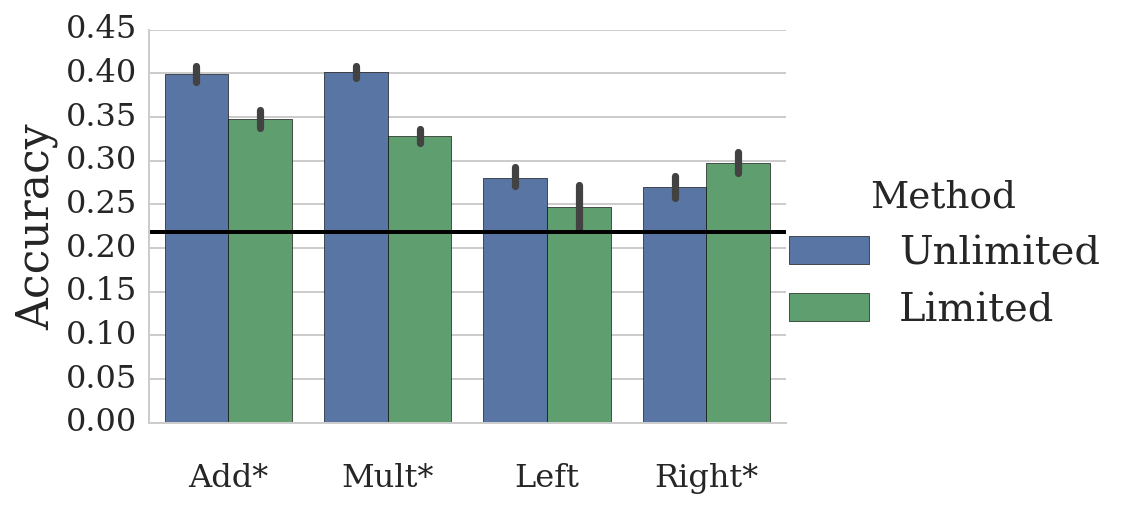

In [3]:
experiments = Experiment.objects.filter(expansions__entries_of__isnull=False, 
                                        expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in experiments]

plot_matching(experiments, labels=names)
plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage1.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# word2vec reduced to coverage of count windows (there shouldn't be a large difference)

[215, 217, 219, 221] ---> [34, 35, 36, 37]


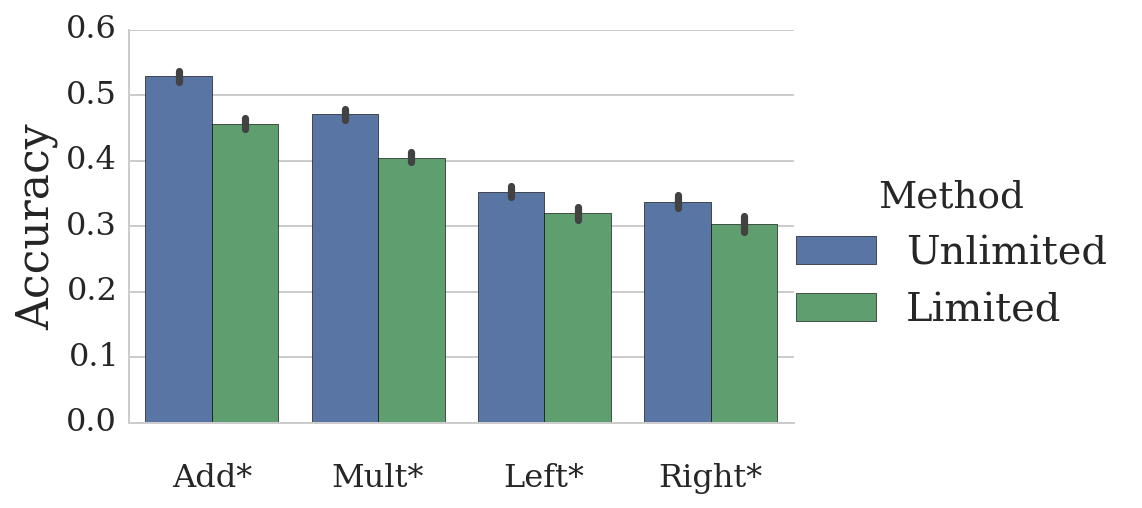

In [4]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__algorithm='count_windows'
                                   ).exclude(expansions__entries_of__composer='Baroni')
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
# plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# wiki-100 reduced to coverage of wiki-15 

[310, 311, 312, 313] ---> [34, 35, 36, 37]


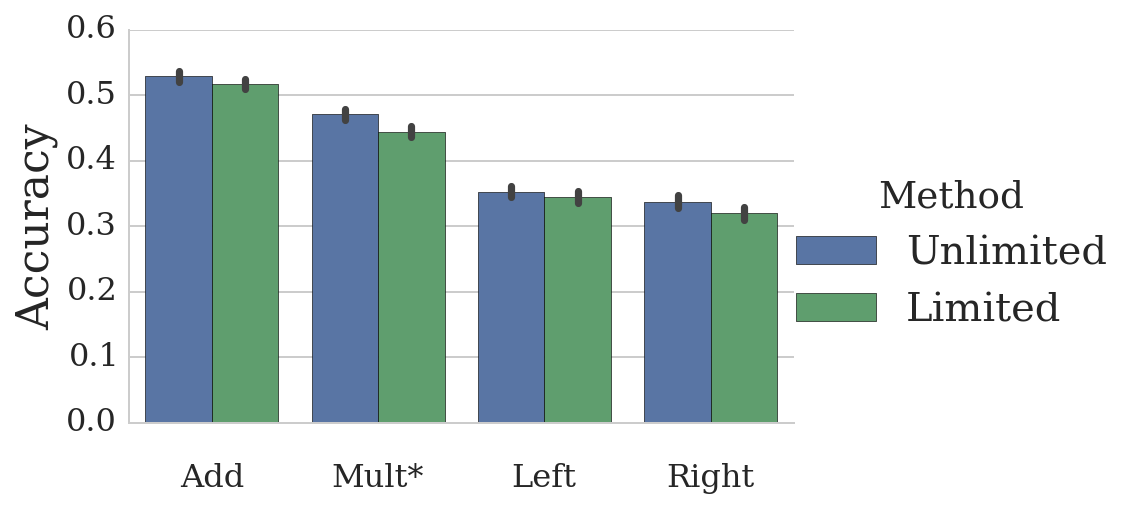

In [5]:
exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__vectors__unlabelled_percentage=100,
                                    expansions__entries_of__unlabelled_percentage=15)
names = [n.expansions.vectors.composer for n in exp_ids]
plot_matching(exp_ids, labels=names)
# plt.axhline(random_vect_baseline(), c='k');
plt.savefig('plot-reduced-coverage3.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Learning curve with reduced coverage
An extended version of the above cell

In [6]:
constrained_exp_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                    expansions__entries_of__unlabelled_percentage=15,
                                    expansions__vectors__composer='Add').values_list('id', flat=True)
print(constrained_exp_ids)

[310, 334, 335, 336, 337, 338, 339, 340, 341]


In [17]:
unconstrained_exp_ids = []

s = settings_of(eid)
s['expansions__entries_of_id'] = None
del s['expansions__vectors__unlabelled_percentage']
unconstrained_exp_ids = Experiment.objects.filter(**s).values_list('id', flat=True)
print(unconstrained_exp_ids, '-->', constrained_exp_ids)

[34, 87, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122] --> [310, 334, 335, 336, 337, 338, 339, 340, 341]


In [18]:
names = {'percent':'expansions__vectors__unlabelled_percentage'}
df1 = dataframe_from_exp_ids(unconstrained_exp_ids, names)
df1['kind'] = 'Unlimited'
df2 = dataframe_from_exp_ids(constrained_exp_ids, names)
df2['kind'] = 'Limited'

folds has 6000 values
percent has 6000 values
Accuracy has 6000 values
folds has 4500 values
percent has 4500 values
Accuracy has 4500 values


In [19]:
df = pd.concat([df1, df2], ignore_index=True).convert_objects(convert_numeric=True)

In [20]:
df.head()

,Accuracy,folds,percent,kind
0,0.516550,0,100,Unlimited
1,0.516619,1,100,Unlimited
2,0.517863,2,100,Unlimited
3,0.518278,3,100,Unlimited
4,0.518485,4,100,Unlimited


In [26]:
df.percent.describe()

count    10500.000000
mean        52.666667
std         29.982904
min          1.000000
25%         30.000000
50%         50.000000
75%         80.000000
max        100.000000
Name: percent, dtype: float64

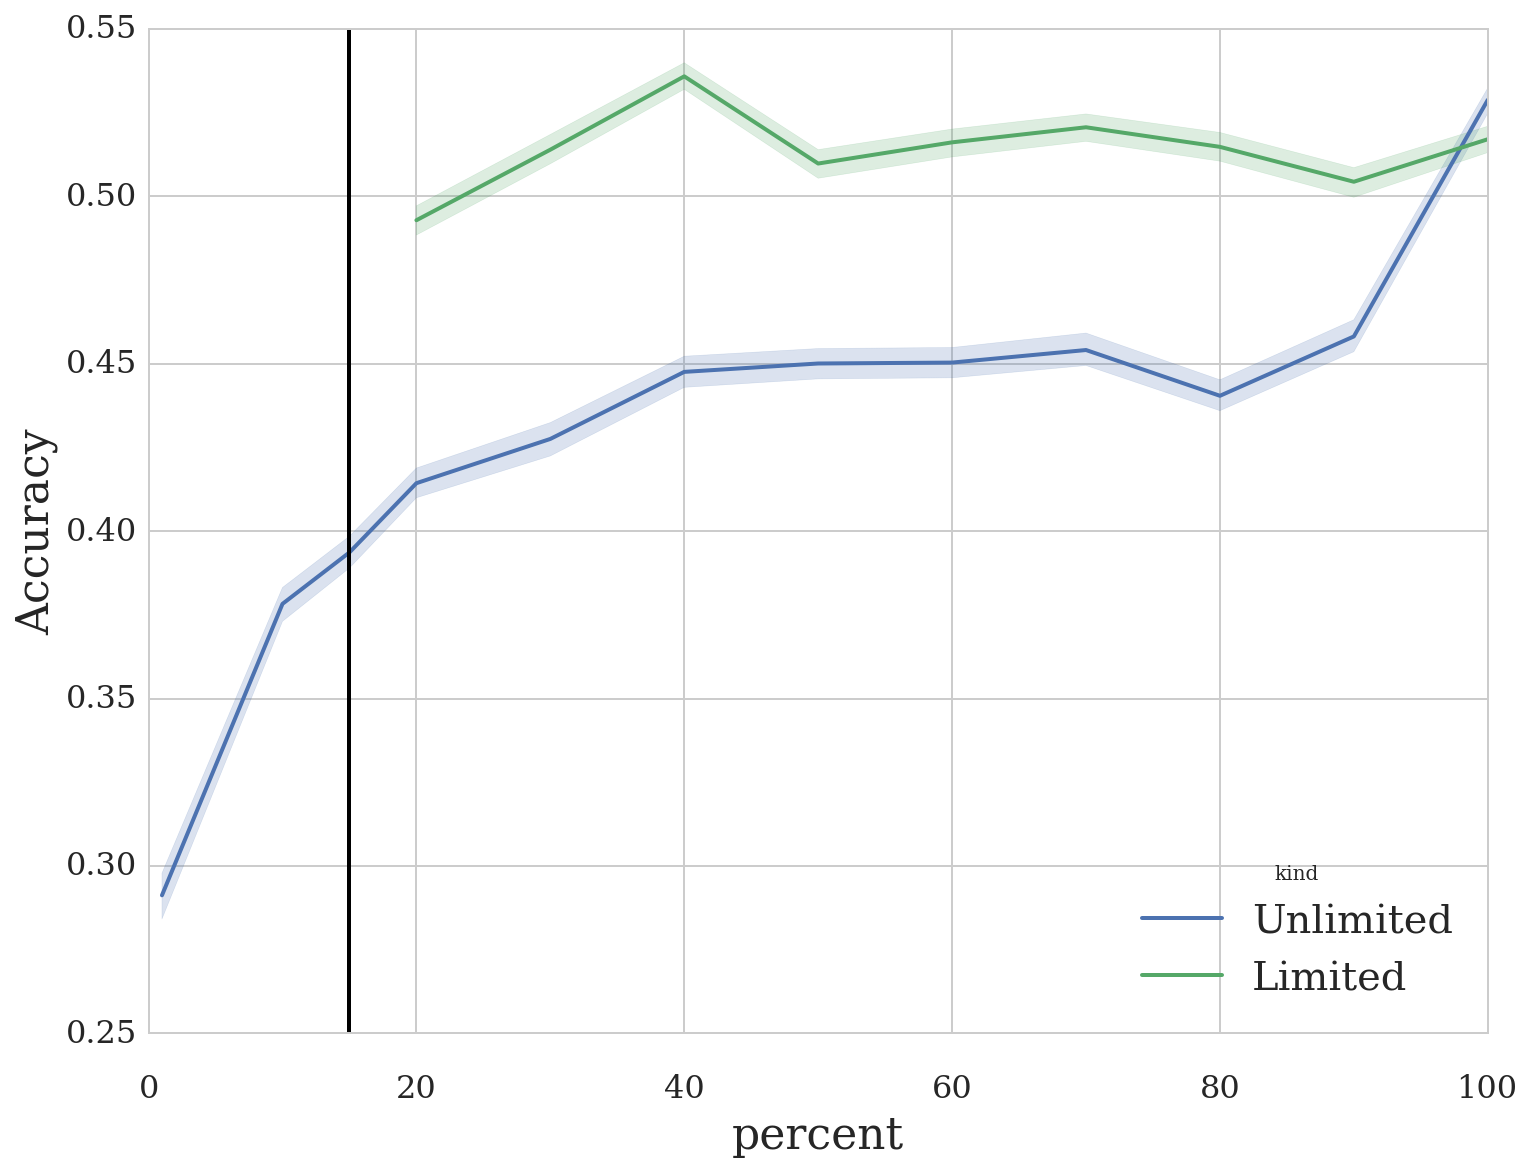

In [30]:
ax = sns.tsplot(df, time='percent', unit='folds', condition='kind', value='Accuracy')
plt.xlim(0, 100)
plt.axvline(15, c='k')